In [1]:
from clustering_utils import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Load data

In [2]:
X = pd.read_pickle('Data/ACs/Dataframes/control_data_features.pkl')

Kernels

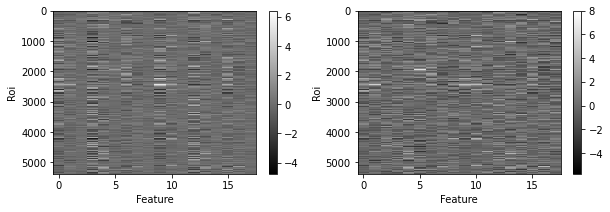

In [3]:
data = np.vstack(X['pca features color - 3 components'].to_numpy())
scaledData = np.zeros_like(data)

# Feature scaling: Mean = 0 and STD = 1 for each feature
for current_index in range(data.shape[1]):
    current_feature = data[:,current_index]
    scaledData[:,current_index] = (current_feature - np.mean(current_feature))/np.std(current_feature)
    
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(data, aspect = 'auto', cmap = 'binary_r', interpolation = 'None')
plt.ylabel('Roi')
plt.xlabel('Feature')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(scaledData, aspect = 'auto', cmap = 'binary_r', interpolation = 'None')
plt.ylabel('Roi')
plt.xlabel('Feature')
plt.colorbar()
plt.show()

Run GMM

In [4]:
replicate = 16
covariance_type = 'diag'
nb_of_components = 25
max_iterations = 1000

columns = ['Seed', 'Covariance type', 'Nb components', 'Max iterations', 'BIC', 'Score', 'Predictions']
gmm_results = pd.DataFrame(columns = columns)

gmm = GaussianMixture(n_components=nb_of_components,
                      covariance_type=covariance_type,
                      max_iter=max_iterations,                                     
                      random_state=replicate)

labels = gmm.fit_predict(scaledData)
BIC = gmm.bic(scaledData)
score = gmm.score(scaledData)

current_data = {'Seed': replicate,
                'Covariance type': covariance_type,
                'Nb components': nb_of_components,
                'Max iterations': max_iterations,
                'BIC': BIC,
                'Score': score,
                'Predictions': labels}

gmm_results = pd.concat([gmm_results, pd.DataFrame([current_data], columns=columns)],
                        ignore_index=True)

In [5]:
gmm_results

,Seed,Covariance type,Nb components,Max iterations,BIC,Score,Predictions
0,16,diag,25,1000,239947.157552,-21.57028,"[10, 23, 23, 10, 23, 24, 23, 23, 23, 23, 8, 24..."


Sample from GMM and predict labels

In [6]:
sampledData, trueLabels = gmm.sample(10000)
predictedLabels = gmm.predict(sampledData)
assert len(trueLabels) == len(predictedLabels)

In [7]:
trueLabels_df = pd.DataFrame()
trueLabels_df['cluster ID (diag)'] = trueLabels

predictedLabels_df = pd.DataFrame()
predictedLabels_df['cluster ID (diag)'] = predictedLabels

Permute labels

In [8]:
def permute_clusterIDs_wControl(dataframe, clustering_name, control_df):
    
    cluster_IDs = dataframe[clustering_name].to_numpy()
    cluster_IDs_control = control_df[clustering_name].to_numpy()
    assert np.amin(cluster_IDs) == 0
    nb_clusters = np.unique(cluster_IDs).shape[0]
    IPL_depth = dataframe['ipl_depth'].to_numpy()
    
    cluster_locations = np.zeros(nb_clusters)
    for current_cluster in range(nb_clusters):
        clusterMask = np.where(cluster_IDs == current_cluster)[0]
        cluster_locations[current_cluster] = np.median(IPL_depth[clusterMask])
    
    new_cluster_IDs = 100*np.ones(len(dataframe))
    new_cluster_IDs_control = 100*np.ones(len(control_df))
    for new_ID, old_ID in enumerate(np.argsort(cluster_locations)):
        new_cluster_IDs[np.where(cluster_IDs == old_ID)[0]] = int(new_ID)
        new_cluster_IDs_control[np.where(cluster_IDs_control == old_ID)[0]] = int(new_ID)
    
    return new_cluster_IDs, new_cluster_IDs_control

In [9]:
df = pd.read_pickle('Data/ACs/Dataframes/control_data_features.pkl')
df_labels = pd.read_pickle('Data/ACs/Dataframes/control_data_gmm_pcaColor_3Components_labels.pkl')
df['cluster ID (diag)'] = gmm_results['Predictions'].to_numpy()[0]

original_labels_new, trueLabels_new = permute_clusterIDs_wControl(df, 'cluster ID (diag)', trueLabels_df)
_, predictedLabels_new = permute_clusterIDs_wControl(df, 'cluster ID (diag)', predictedLabels_df)

assert np.all(original_labels_new == df_labels['cluster ID (diag)'].to_numpy())

Calculate confusion matrix and accuracy

In [10]:
conf_matrix = confusion_matrix(trueLabels_new, predictedLabels_new)

TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis = 0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis = 1) - np.diag(conf_matrix)
TN = conf_matrix.sum() - TP - FP - FN

ACC = (TP + TN)/(TP + TN + FP + FN)
print(ACC)

[0.9989 0.9731 0.9778 0.9971 0.9961 0.9929 0.9914 0.9829 0.9917 0.9999
 0.9949 0.9954 0.9988 0.9994 0.9983 0.9984 0.9936 0.9969 0.9982 0.9943
 0.9832 0.9923 0.9812 0.9981 0.9742]


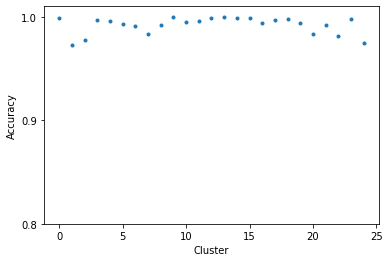

In [11]:
plt.plot(ACC, '.')
plt.ylabel('Accuracy')
plt.xlabel('Cluster')
plt.ylim([0.8,1.01])
plt.yticks([0.8,0.9,1])
plt.show()

In [12]:
print(np.amin(ACC))

0.9731
